<div style="text-align: center">
<h1>INFO 6105 Data Sci Engineering Methods and Tools</h1>
</div>
<div style="text-align: center">
<h2>FINAL PROJECT</h2>
</div>
<div style="text-align: center">
<h3>Sentiment Analysis Reddit Comments</h3>
</div>

In [17]:
import requests
import numpy as np
import pandas as pd
import json
from datetime import datetime
import plotly.express as px
import textblob
from textblob.classifiers import NaiveBayesClassifier
import sklearn
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [18]:
# epoch time corresponding to Tuesday, 31 December 2019 0:00:00 GMT
start_date = 1577750400
now = datetime.now()
now_epoch = now.timestamp()
end_date = int(now_epoch)
df_final = pd.DataFrame()

In [21]:
#defining a function that will make an API call to pushshift which will return the reditt comments
def get_pushshift_data(base_url, **kwargs):
    base_url = 'https://api.pushshift.io/reddit/search/comment/?'
    params = kwargs
    request = requests.get(base_url, params=kwargs)
    return request.json()
while start_date <= end_date:
    data = get_pushshift_data(base_url = 'https://api.pushshift.io/reddit/search/comment/?',
                              q='coronavirus',
                              after=str(start_date),
                              before=str(start_date+86400), 
                              size=500,
                              sort_type='score',
                              sort='desc').get('data')
    #print(data)
    if data == None:
        start_date = start_date + 86400
    else:
        df = pd.DataFrame.from_records(data)
        df_final= df_final.append(df)
        start_date = start_date + 86400

# Let's keep only some columns for our final database
df_final = df_final[['created_utc', 'author', 'subreddit', 'body', 'score', 'permalink']]

# Let's create a new column with all the epoch dates converted
df_final['date'] = pd.to_datetime(df_final['created_utc'], unit='s')

In [22]:
# Let's keep only some columns for our final database
df_final['date'] = pd.to_datetime(df_final['created_utc'], unit='s')
df_final['date'] = df_final['date'].values.astype(int)
df_final = df_final[['created_utc','date', 'author', 'subreddit', 'body', 'score', 'permalink']]

In [23]:
# Let's create a new column with all the epoch dates converted

df_final.head()

,created_utc,date,author,subreddit,body,score,permalink
0,1577841828,1706125312,Jouhou,China,"Honestly, the the Chinese climate and the high...",1,/r/China/comments/ehx3sw/an_unidentified_type_...
1,1577851876,-517347328,ImpracticalCats,VetTech,"This is interesting, I googled to try to figur...",1,/r/VetTech/comments/ei57ml/hello_anybody_here_...
0,1577992294,2116844544,murky_comparison,puppy101,"Immunity, even if the dog has experienced a na...",8,/r/puppy101/comments/ej2i1i/how_do_you_feel_ab...
1,1577949412,1070327808,MyrkyCat,Seattle,That symptom is not pathognomonic for RSV by a...,1,/r/Seattle/comments/ehnilr/what_the_heck_kind_...
0,1578086182,2131753984,murky_comparison,dogs,Not necessarily just curious! For vaccines wil...,3,/r/dogs/comments/ejl7r4/help_hi_rdogs_were_loo...


In [24]:
#We are going to use the NLP library Textblob for our first approach into a Sentiment Analysis of our data.
import textblob
import textblob

# create a column with sentiment polarity
df_final["sentiment_polarity"] = df_final.apply(lambda row: textblob.TextBlob(row["body"]).sentiment.polarity, axis=1)

# create a column with sentiment subjectivity
df_final["sentiment_subjectivity"] = df_final.apply(lambda row: textblob.TextBlob(row["body"]).sentiment.subjectivity, axis=1)

# create a column with 'positive' or 'negative' depending on sentiment_polarity
df_final["sentiment"] = df_final.apply(lambda row: "positive" if row["sentiment_polarity"] >= 0 else "negative", axis=1)

# create a column with a text preview that shows the first 50 characters
df_final["preview"] = df_final["body"].str[0:50]
df_final.head()

,created_utc,date,author,subreddit,body,score,permalink,sentiment_polarity,sentiment_subjectivity,sentiment,preview
0,1577841828,1706125312,Jouhou,China,"Honestly, the the Chinese climate and the high...",1,/r/China/comments/ehx3sw/an_unidentified_type_...,0.139493,0.478382,positive,"Honestly, the the Chinese climate and the high..."
1,1577851876,-517347328,ImpracticalCats,VetTech,"This is interesting, I googled to try to figur...",1,/r/VetTech/comments/ei57ml/hello_anybody_here_...,0.056818,0.586364,positive,"This is interesting, I googled to try to figur..."
0,1577992294,2116844544,murky_comparison,puppy101,"Immunity, even if the dog has experienced a na...",8,/r/puppy101/comments/ej2i1i/how_do_you_feel_ab...,0.227778,0.370833,positive,"Immunity, even if the dog has experienced a na..."
1,1577949412,1070327808,MyrkyCat,Seattle,That symptom is not pathognomonic for RSV by a...,1,/r/Seattle/comments/ehnilr/what_the_heck_kind_...,-0.017500,0.532500,negative,That symptom is not pathognomonic for RSV by a...
0,1578086182,2131753984,murky_comparison,dogs,Not necessarily just curious! For vaccines wil...,3,/r/dogs/comments/ejl7r4/help_hi_rdogs_were_loo...,0.091875,0.745625,positive,Not necessarily just curious! For vaccines wil...


In [25]:
df_final.to_csv(path_or_buf='covid19_comments.csv')

In [26]:
#check if there are any null values in our dataset
print(pd.read_csv('covid19_comments.csv').isnull().values.any())

False


In [27]:
df_final.groupby('score')['score'].count().sort_values(ascending=False)


score
 1      7899
 2      4700
 3      3384
 4      2462
 5      2436
        ... 
 242       1
 240       1
 239       1
 237       1
-1         1
Name: score, Length: 313, dtype: int64

In [28]:
df_final['score'].replace(to_replace=-1, value=1, inplace=True)
df_final.groupby('score')['score'].count().sort_values(ascending=False)

score
1      7900
2      4700
3      3384
4      2462
5      2436
       ... 
242       1
240       1
239       1
237       1
0         1
Name: score, Length: 312, dtype: int64

In [29]:
#split the comments we retrieved from Reddit for each month they were created.
#First, we can see below these lines the distribution of comments from the first month of 2020 until now.

df_final['month'] = pd.DatetimeIndex(df_final['date']).month
df_final.groupby('month')['month'].count().sort_values(ascending=False)

month
12    20776
1     20719
Name: month, dtype: int64

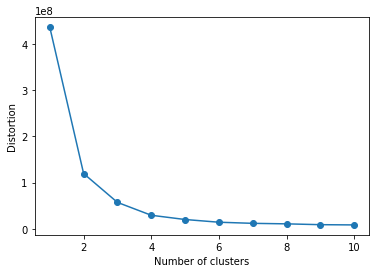

In [30]:
#Let's use K-means clustering to clasify the comments in different clusters.
#First we are going to use the Elbow Method to determine the best value for k.
df_km = pd.DataFrame(df_final['score'])
df_km['sentiment_polarity'] = df_final['sentiment_polarity']

# ELBOW METHOD

# calculate distortion for a range of number of cluster
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(df_km)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [31]:
kclusters = 4

km = KMeans(n_clusters=kclusters, init='random',n_init=10, max_iter=300, 
    tol=1e-04, random_state=0).fit(df_km)

km_labels = km.labels_

# Let's change label numbers so they go from highest scores to lowest

replace_labels = {0:2, 1:0, 2:3, 3:1}

for i in range(len(km_labels)):
    km_labels[i] = replace_labels[km_labels[i]]
    
df_km['Cluster'] = km_labels
df_km.head()

,score,sentiment_polarity,Cluster
0,1,0.139493,2
1,1,0.056818,2
0,8,0.227778,2
1,1,-0.017500,2
0,3,0.091875,2


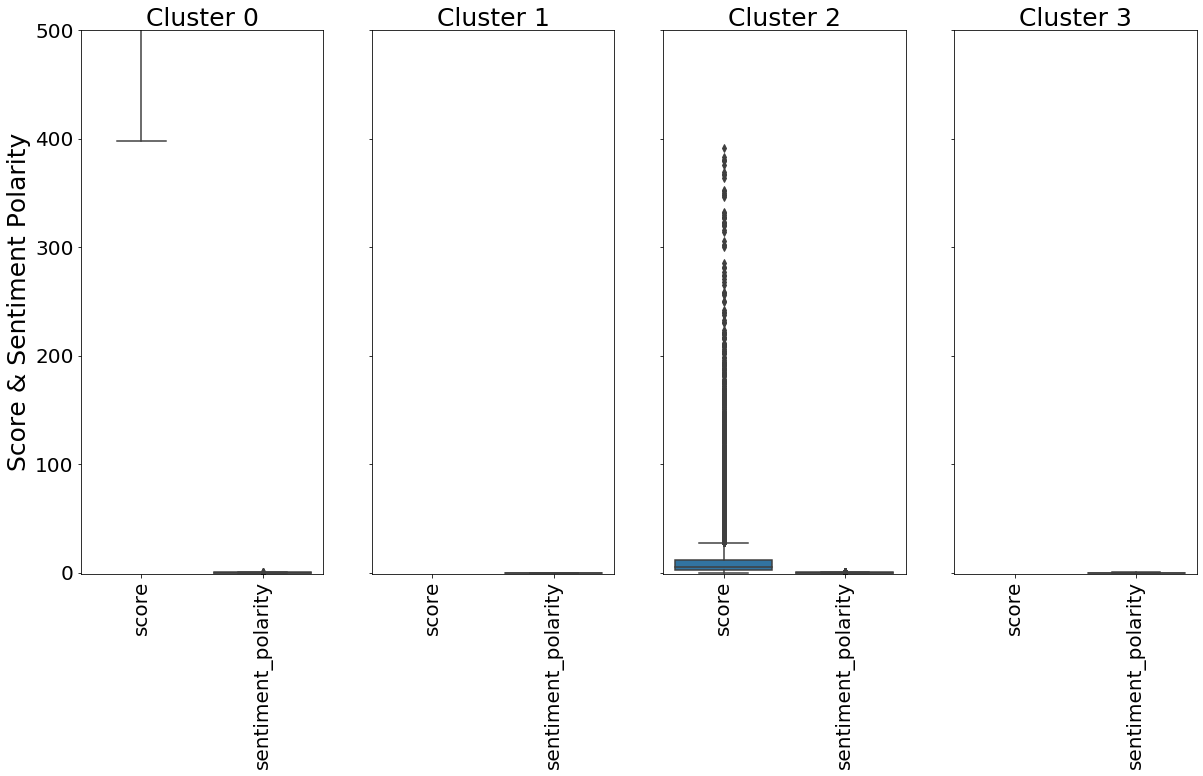

In [32]:
import matplotlib.ticker as ticker

fig, axes = plt.subplots(1, kclusters, figsize=(20, 10), sharey=True)

axes[0].set_ylabel('Score & Sentiment Polarity', fontsize=25)

for k in range(kclusters):
    # We are going to set same y axis limits
    axes[k].set_ylim(-1,500)
    axes[k].xaxis.set_label_position('top')
    axes[k].set_xlabel('Cluster ' + str(k), fontsize=25)
    axes[k].tick_params(labelsize=20)
    plt.sca(axes[k])
    plt.xticks(rotation='vertical')
    sns.boxplot(data = df_km[df_km['Cluster'] == k].drop('Cluster',1), ax=axes[k])

plt.show()

In [33]:
df_final['Cluster'] = df_km['Cluster']

df_cluster1 = df_final.loc[df_final['Cluster'] == 0]
fig = px.scatter(df_cluster1, x="date",
           y="sentiment_polarity", 
           trendline = 'lowess',
           hover_data=["author", "permalink", "preview"], 
           color_discrete_sequence=["green", "red"], 
           color="sentiment", 
           size="score", 
           size_max=50,
           labels={"sentiment_polarity": "Comment positivity", "date": "Date comment was posted"}, 
           title=f"Sentiment of Reddit's most-voted comments on COVID-19",
          )
fig.update_layout(
    autosize=False,
    width=800,
    height = 800,
    plot_bgcolor = 'white'
)
fig.show()